In [164]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,SpatialDropout1D,Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from bs4 import BeautifulSoup


In [165]:
df = pd.read_csv('consumer_complaints.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [166]:
df = df[['product','consumer_complaint_narrative']]

In [167]:
df.head()

,product,consumer_complaint_narrative
0,Mortgage,NaN
1,Mortgage,NaN
2,Credit reporting,NaN
3,Student loan,NaN
4,Debt collection,NaN


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 2 columns):
product                         555957 non-null object
consumer_complaint_narrative    66806 non-null object
dtypes: object(2)
memory usage: 8.5+ MB


In [169]:
df = df[pd.notnull(df['consumer_complaint_narrative'])]

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 2 columns):
product                         66806 non-null object
consumer_complaint_narrative    66806 non-null object
dtypes: object(2)
memory usage: 1.5+ MB


In [171]:
df.head()

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [172]:
df['product'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64

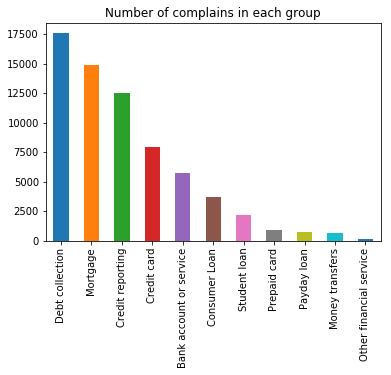

In [173]:
df['product'].value_counts().sort_values(ascending=False).plot.bar(title = 'Number of complains in each group')

In [174]:
df.iloc[10]['consumer_complaint_narrative']

'I am very disappointed that the CFPB did not help to resolve this fraudulant loan. # XXXX between XXXX XXXX and XXXX, FF ( AKA ) One West. Case # XXXX with CFPB. \n'

In [175]:
df.iloc[50]['consumer_complaint_narrative']

"We opened an account with Freedom Funiture in XXXX paid as agreed and refinanced in XXXX. We paid as agreed until we became unable to pay the full amount in XXXX. We made an agreement to pay a lesser amount per month and kept paying via allotment. Freedom got a judgement against us while I was training. I was not served with the judgement prior to court or after ... I was informed of it when my wages began to be garnished. They got the judgement in XXXX VA. XXXX # XXXX Filed XXXX. \nI did not sign a contract in VA I signed my contract in GA. They garnished my wages causing finacial distress. I was able to get that stopped through XXXX. However the judgement remains and has severely damaged our credit preventing us from buying a home and upgrading our vehicles. We have asked repeatedly to have this issue fixed based on the fact that the judgement was not served on me ever and the fact that they have caused so much financial distress and ruin. We were told we 'd have to go to VA to fix 

# Text preprocessing

In [176]:
df = df.reset_index(drop = True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+ _]')
XX_RE=re.compile('x{2,10}')
#STOPWORDS = set(stopwords.words)

In [177]:
a =df.iloc[50]['consumer_complaint_narrative']
a=a.lower()
a

"we opened an account with freedom funiture in xxxx paid as agreed and refinanced in xxxx. we paid as agreed until we became unable to pay the full amount in xxxx. we made an agreement to pay a lesser amount per month and kept paying via allotment. freedom got a judgement against us while i was training. i was not served with the judgement prior to court or after ... i was informed of it when my wages began to be garnished. they got the judgement in xxxx va. xxxx # xxxx filed xxxx. \ni did not sign a contract in va i signed my contract in ga. they garnished my wages causing finacial distress. i was able to get that stopped through xxxx. however the judgement remains and has severely damaged our credit preventing us from buying a home and upgrading our vehicles. we have asked repeatedly to have this issue fixed based on the fact that the judgement was not served on me ever and the fact that they have caused so much financial distress and ruin. we were told we 'd have to go to va to fix 

In [178]:
REPLACE_BY_SPACE_RE.sub(' ',a)

"we opened an account with freedom funiture in xxxx paid as agreed and refinanced in xxxx. we paid as agreed until we became unable to pay the full amount in xxxx. we made an agreement to pay a lesser amount per month and kept paying via allotment. freedom got a judgement against us while i was training. i was not served with the judgement prior to court or after ... i was informed of it when my wages began to be garnished. they got the judgement in xxxx va. xxxx # xxxx filed xxxx. \ni did not sign a contract in va i signed my contract in ga. they garnished my wages causing finacial distress. i was able to get that stopped through xxxx. however the judgement remains and has severely damaged our credit preventing us from buying a home and upgrading our vehicles. we have asked repeatedly to have this issue fixed based on the fact that the judgement was not served on me ever and the fact that they have caused so much financial distress and ruin. we were told we 'd have to go to va to fix 

In [179]:
a=BAD_SYMBOLS_RE.sub('',a)
a

'we opened an account with freedom funiture in xxxx paid as agreed and refinanced in xxxx we paid as agreed until we became unable to pay the full amount in xxxx we made an agreement to pay a lesser amount per month and kept paying via allotment freedom got a judgement against us while i was training i was not served with the judgement prior to court or after  i was informed of it when my wages began to be garnished they got the judgement in xxxx va xxxx # xxxx filed xxxx i did not sign a contract in va i signed my contract in ga they garnished my wages causing finacial distress i was able to get that stopped through xxxx however the judgement remains and has severely damaged our credit preventing us from buying a home and upgrading our vehicles we have asked repeatedly to have this issue fixed based on the fact that the judgement was not served on me ever and the fact that they have caused so much financial distress and ruin we were told we d have to go to va to fix it we have in tota

In [180]:
a = XX_RE.sub('',a)
a

'we opened an account with freedom funiture in  paid as agreed and refinanced in  we paid as agreed until we became unable to pay the full amount in  we made an agreement to pay a lesser amount per month and kept paying via allotment freedom got a judgement against us while i was training i was not served with the judgement prior to court or after  i was informed of it when my wages began to be garnished they got the judgement in  va  #  filed  i did not sign a contract in va i signed my contract in ga they garnished my wages causing finacial distress i was able to get that stopped through  however the judgement remains and has severely damaged our credit preventing us from buying a home and upgrading our vehicles we have asked repeatedly to have this issue fixed based on the fact that the judgement was not served on me ever and the fact that they have caused so much financial distress and ruin we were told we d have to go to va to fix it we have in total paid this company nearly 25000

In [185]:
def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ',text) # substitude the matches string in REPLACE_BY_SPACE_RE with space
    text = BAD_SYMBOLS_RE.sub('',text) #substitude the matched string in BAD_SYMBOLS_RE with nothing
    text = XX_RE.sub('',text) # Remove 'xxx' in text
    text = ' '.join(word for word in text.split())
    return text

In [187]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(clean_text)
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].str.replace('\d+','') # remove digits in text

In [188]:
df.head()

,product,consumer_complaint_narrative
0,Debt collection,has claimed i owe them for years despite the ...
1,Consumer Loan,due to inconsistencies in the amount owed that...
2,Mortgage,in my wages that i earned at my job decreased ...
3,Mortgage,i have an open and current mortgage with chase...
4,Mortgage,was submitted at the time i submitted this com...


# LSTM Modeling

In [200]:
MAX_NUM_WORDS = 50000 # LIMIT THE DATASET TO THE TOP 50000 WORDS
MAX_SEQUENCE_LENGTH = 250 # set the max number of words in each complaint to be 250
EMBEDDING_DIM =100

tokenizer = Tokenizer(num_words = MAX_NUM_WORDS,filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',lower = True)
tokenizer.fit_on_texts(df['consumer_complaint_narrative'])
word_index = tokenizer.word_index

In [196]:
print('There is %s unique tokens' %len(word_index))

There is 56995 unique tokens


In [201]:
X= tokenizer.texts_to_sequences(df['consumer_complaint_narrative'])
X = pad_sequences(X,maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor', X.shape)

Shape of data tensor (66806, 250)


In [203]:
Y = pd.get_dummies(df['product'])
print('Shape of label tensor', Y.shape)

Shape of label tensor (66806, 11)


In [204]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state = 0)

# Build the model

In [217]:
model = Sequential()
model.add(Embedding(input_dim = MAX_NUM_WORDS,output_dim = EMBEDDING_DIM,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100,dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(11,activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [215]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1111      
Total params: 5,081,511
Trainable params: 5,081,511
Non-trainable params: 0
_________________________________________________________________


In [221]:
epochs = 2
batch_size = 64
history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch_size,validation_split = 0.1)

Train on 45093 samples, validate on 5011 samples
Epoch 1/2
45093/45093 [==============================] - 1203s 27ms/step - loss: 0.9565 - acc: 0.7089 - val_loss: 0.8371 - val_acc: 0.7440
Epoch 2/2
45093/45093 [==============================] - 1008s 22ms/step - loss: 0.7385 - acc: 0.7749 - val_loss: 0.6972 - val_acc: 0.7839


In [222]:
accuracy = model.evaluate(X_test,Y_test)
print('Test set \n loss: %f\n accuracy: %f \n'%(accuracy[0],accuracy[1]))

16702/16702 [==============================] - 136s 8ms/step
Test set 
 loss: 0.681469
 accuracy: 0.791941 

